In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import random
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import backend as K
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix


Mount Google Drive and List Directories in a Specified Path



In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive to access files and directories
path = '/content/drive/MyDrive/עבודה בינה מלאכותית/data_base'  # Define the target path in Google Drive
directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))] # List all directories in the specified path

print(directories)  # Print the list of directories


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['nonpd', 'pd', 'Prodromal', 'תמונות תסמינים שלא השתמשנו בהם לפיתוח מודל בגלל עודף']


Define Source Directories and Data Split Ratios

In [ ]:
import os
import pandas as pd
import random

# אסור להריץ
# נתיב לתקיות החולים והלא חולים

patients_dir = path + r'/pd'
healthy_dir = path + r'/nonpd'

healthy_df =  pd.read_csv(path + r'/Healthy_list_for_model_1,2.csv')

# יצירת רשימות של התמונות והלייבלים
images = []
labels = []

# הוספת תמונות חולים
for filename in os.listdir(patients_dir):
    images.append(os.path.join(patients_dir, filename))
    labels.append('PD')

random.seed(25)
random.shuffle(images)

images = images[:healthy_df.shape[0]]
labels = labels[:len(images)]


# הוספת תמונות לא חולים
for _, row in healthy_df.iterrows():
    filename = str(row['File Name'])
    images.append(os.path.join(healthy_dir, filename))
    labels.append('NONPD')

# צעד 3: יצירת דאטה פריים
df = pd.DataFrame({
    'Image': images,
    'Label': labels
})


print(f'pd - nonpd ratio -> {df[df["Label"] == "PD"].shape[0]//df[df["Label"] == "NONPD"].shape[0] }:1')


# הצגת הדאטה פריים
df.head()

pd - nonpd ratio -> 1:1


,Image,Label
0,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,PD
1,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,PD
2,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,PD
3,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,PD
4,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,PD



Load and Preprocess Image Dataset with Train, Validation, and Test Splits

In [ ]:

# Paths to the folders
patients_dir = path + '/pd'  # Directory containing patient (PD) images
nonpatients_dir = path + '/nonpd'  # Directory containing non-patient (NONPD) imagesDirectory containing non-patient (NONPD) images

# Parameters for dataset splitting
TRAIN_SPLIT = 0.64  # Fraction of data for training
VAL_SPLIT = 0.16    # Fraction of data for validation
TEST_SPLIT = 0.20   # Fraction of data for testing
SEED = 42           # Random seed for reproducibility


# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=(1 - TRAIN_SPLIT), random_state=SEED, stratify=df["Label"])
val_df, test_df = train_test_split(temp_df, test_size=(TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)), random_state=SEED, stratify=temp_df["Label"])

# Function to load a dataset from a DataFrame
def load_dataset(dataframe, image_size, batch_size, shuffle=True):
    file_paths = dataframe["Image"].values  # Extract file paths
    labels = dataframe["Label"].values  # Extract labels
    labels = np.where(labels == 'PD', 1, 0)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))  # Create TensorFlow dataset
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=SEED)  # Shuffle data if needed

    def load_and_preprocess_image(file_path, label):
        img = tf.io.read_file(file_path)  # Read image file
        img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG images; use decode_png for PNG
        img = tf.image.resize(img, image_size)  # Resize image to specified dimensions
        return img, label

    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)  # Apply preprocessing
    return dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)  # Batch and prefetch data

# Parameters for loading the dataset
IMG_SIZE = (224, 224)  # Image dimensions
BATCH_SIZE = 32  # Batch size

# Load datasets
train_ds = load_dataset(train_df, IMG_SIZE, BATCH_SIZE, shuffle=True)  # Training dataset
val_ds = load_dataset(val_df, IMG_SIZE, BATCH_SIZE, shuffle=True)  # Validation dataset
test_ds = load_dataset(test_df, IMG_SIZE, BATCH_SIZE, shuffle=False)  # Test dataset

# The datasets `train_ds`, `val_ds`, and `test_ds` are now ready for use


Optimize Dataset Prefetching for Improved Performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE  # Enable TensorFlow's automatic tuning for performance optimization

train_ds = train_ds.prefetch(AUTOTUNE)  # Prefetch training dataset for faster loading
val_ds   = val_ds.prefetch(AUTOTUNE)   # Prefetch validation dataset for faster loading
test_ds  = test_ds.prefetch(AUTOTUNE)  # Prefetch test dataset for faster loading


Define a Data Augmentation Layer for Preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.005),       # Apply a small random rotation (0.5%)
    layers.RandomZoom(0.1),             # Apply a small random zoom
    layers.RandomContrast(0.05),        # Apply a slight random contrast adjustment
], name="augmentation_layer")  # Name the layer for easier identification


Map Data Augmentation and Preprocessing Functions to Datasets

In [ ]:
def augment_and_preprocess(image, label):
    image = data_augmentation(image)  # Apply data augmentation to the image
    image = preprocess_input(image)  # Preprocess the image for ResNet50
    return image, label

def preprocess_only(image, label):
    image = preprocess_input(image)  # Preprocess the image for ResNet50 without augmentation
    return image, label

train_ds = train_ds.map(augment_and_preprocess, num_parallel_calls=AUTOTUNE)  # Apply augmentation and preprocessing to the training dataset
val_ds = val_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)             # Apply preprocessing only to the validation dataset
test_ds = test_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)           # Apply preprocessing only to the test dataset


Define a Custom F1 Score Metric for TensorFlow/Keras with Improved Casting

In [ ]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # Convert both y_true and y_pred to float32 to prevent data type issues
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    tp = K.sum(K.round(y_true * y_pred))  # Calculate true positives
    predicted_positives = K.sum(K.round(y_pred))  # Calculate predicted positives
    possible_positives  = K.sum(K.round(y_true))  # Calculate possible positives

    precision = tp / (predicted_positives + K.epsilon())  # Calculate precision
    recall    = tp / (possible_positives + K.epsilon())   # Calculate recall

    # Return the F1 score: harmonic mean of precision and recall
    return 2 * (precision * recall) / (precision + recall + K.epsilon())


Build a Transfer Learning Model with ResNet50 as the Base

In [ ]:

base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Use pre-trained weights from ImageNet
    include_top=False,   # Exclude the fully connected top layer
    input_shape=IMG_SIZE + (3,)  # Input shape for the model
)
base_model.trainable = False  # Freeze the base model during initial training

# Add a new "head" for classification
inputs = layers.Input(shape=IMG_SIZE + (3,))  # Define input layer
x = base_model(inputs, training=False)  # Pass inputs through the base model
x = layers.GlobalAveragePooling2D()(x)  # Add global average pooling layer
x = layers.Dropout(0.2)(x)  # Add dropout layer with a rate of 0.2
outputs = layers.Dense(1, activation='sigmoid')(x)  # Add output layer with sigmoid activation

model = models.Model(inputs, outputs, name="Light_vs_Severe_ResNet50")  # Create the complete model


Compile and Train the Model with Weighted Classes and Metrics

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Use Adam optimizer with a learning rate of 0.001
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
    metrics=[
        'accuracy',  # Track accuracy during training
        tf.keras.metrics.Precision(name='precision'),  # Track precision
        tf.keras.metrics.Recall(name='recall'),  # Track recall
        f1_score  # Custom F1 score metric
    ]
)

model.summary()  # Print the model summary



Model: "Light_vs_Severe_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Fine-Tune the Last 20 Layers of the Base Model

In [ ]:
# Unfreeze the last 10 layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True  # Allow these layers to be trainable

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a smaller learning rate for fine-tuning
    loss='binary_crossentropy',  # Binary cross-entropy loss
    metrics=[
        'accuracy',  # Track accuracy during training
        tf.keras.metrics.Precision(name='precision'),  # Track precision
        tf.keras.metrics.Recall(name='recall'),  # Track recall
        f1_score  # Custom F1 score metric
    ]
)

FINE_TUNE_EPOCHS = 20  # Number of fine-tuning epochs
history_fine = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=FINE_TUNE_EPOCHS  # Train for additional fine-tuning epochs
)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 177s 9s/step - accuracy: 0.4670 - f1_score: 4.4839 - loss: 0.9605 - precision: 0.4945 - recall: 0.0806 - val_accuracy: 0.5643 - val_f1_score: 5.3646 - val_loss: 0.7951 - val_precision: 0.7647 - val_recall: 0.1857
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 187s 8s/step - accuracy: 0.5396 - f1_score: 8.7887 - loss: 0.7419 - precision: 0.5375 - recall: 0.2292 - val_accuracy: 0.6214 - val_f1_score: 10.2788 - val_loss: 0.6583 - val_precision: 0.7073 - val_recall: 0.4143
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 161s 9s/step - accuracy: 0.6163 - f1_score: 11.7116 - loss: 0.6377 - precision: 0.6610 - recall: 0.4250 - val_accuracy: 0.6071 - val_f1_score: 13.2717 - val_loss: 0.6102 - val_precision: 0.6154 - val_recall: 0.5714
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.6574 - f1_score: 14.8206 - loss: 0.6109 - precision: 0.6846 - recall: 0.5955 - val_accuracy: 0.6429 - val_f1_score: 14.6077 - val_loss: 0.5871 - val_precision: 0.6282 - val_recall

Evaluate the Fine-Tuned Model on the Test Dataset

In [ ]:
# After completing the fine-tuning (history_fine),
# evaluate the model on the test dataset to check final performance:
print("\nEvaluating Fine-Tuned Model on Test Data...")
test_loss, test_acc, test_prec, test_rec, test_f1 = model.evaluate(test_ds)  # Evaluate on test dataset

# Print evaluation results
print(f"Test Loss: {test_loss:.4f}")  # Loss on the test dataset
print(f"Test Accuracy: {test_acc:.4f}")  # Accuracy on the test dataset
print(f"Test Precision: {test_prec:.4f}")  # Precision on the test dataset
print(f"Test Recall: {test_rec:.4f}")  # Recall on the test dataset
print(f"Test F1: {test_f1:.4f}")  # F1 score on the test dataset



Evaluating Fine-Tuned Model on Test Data...
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.8426 - f1_score: 16.8711 - loss: 0.3704 - precision: 0.7898 - recall: 0.9320
Test Loss: 0.3574
Test Accuracy: 0.8531
Test Precision: 0.7925
Test Recall: 0.9545
Test F1: 16.0129


Generate Predictions, Confusion Matrix, and Classification Report for Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


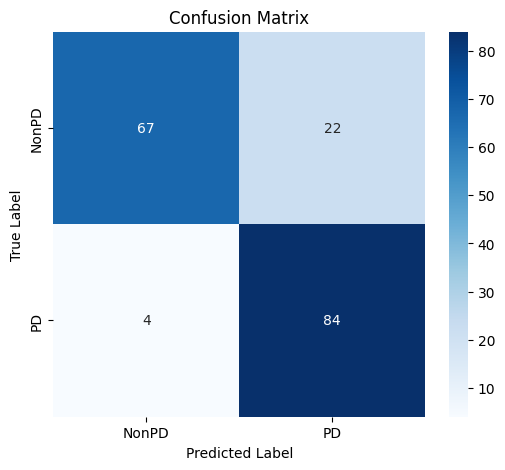


Confusion Matrix:
 [[67 22]
 [ 4 84]]

Classification Report:
               precision    recall  f1-score   support

   nonpd (0)       0.94      0.75      0.84        89
      PD (1)       0.79      0.95      0.87        88

    accuracy                           0.85       177
   macro avg       0.87      0.85      0.85       177
weighted avg       0.87      0.85      0.85       177



In [ ]:
y_true = []  # True labels
y_pred = []  # Predicted labels

# Generate predictions for the test dataset
for images, labels in test_ds:
    preds = model.predict(images)  # Predict probabilities
    y_true.extend(labels.numpy().flatten())  # Collect true labels
    y_pred.extend((preds.flatten() > 0.5).astype(int))  # Convert probabilities to binary predictions


# Assuming you already have y_true and y_pred (true labels and predicted labels)
# y_true = ...
# y_pred = ...

# Step 1: Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 2: Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NonPD", "PD"], yticklabels=["NonPD", "PD"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Generate the classification report
report = classification_report(y_true, y_pred, target_names=["nonpd (0)", "PD (1)"])

# Print results
print("\nConfusion Matrix:\n", cm)  # Display the confusion matrix
print("\nClassification Report:\n", report)  # Display precision, recall, F1-score, and support



Plot Training and Validation Accuracy and Loss Over Epochs

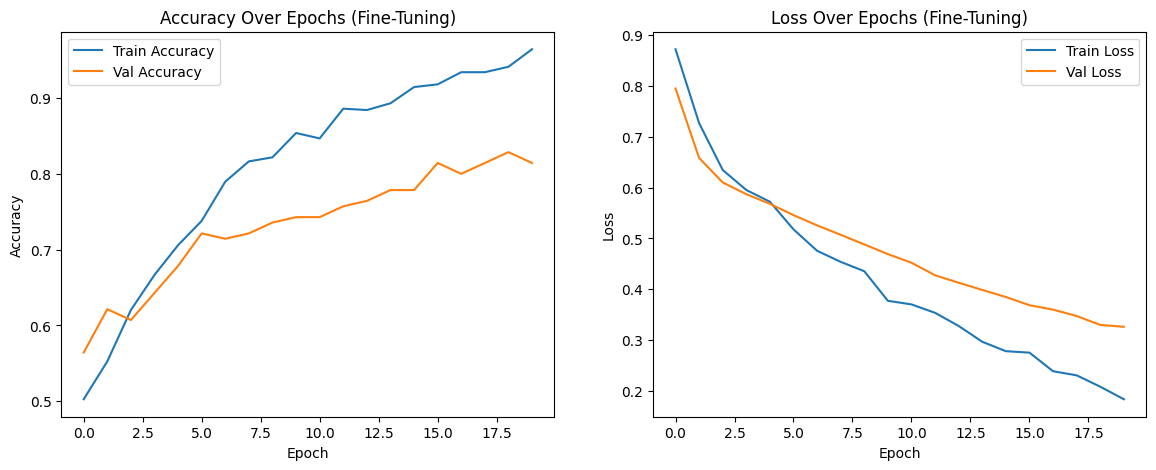

In [ ]:
# עבור רק את ה-fine-tuning
acc = history_fine.history["accuracy"]  # Training accuracy for fine-tuning
val_acc = history_fine.history["val_accuracy"]  # Validation accuracy for fine-tuning
loss = history_fine.history["loss"]  # Training loss for fine-tuning
val_loss = history_fine.history["val_loss"]  # Validation loss for fine-tuning

epochs_range = range(len(acc))  # Total number of epochs for fine-tuning

plt.figure(figsize=(14, 5))

# גרף הדיוק
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")  # Training accuracy plot
plt.plot(epochs_range, val_acc, label="Val Accuracy")  # Validation accuracy plot
plt.title("Accuracy Over Epochs (Fine-Tuning)")  # Title for accuracy plot
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Accuracy")  # Y-axis label
plt.legend()  # Add legend

# גרף ההפסד
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")  # Training loss plot
plt.plot(epochs_range, val_loss, label="Val Loss")  # Validation loss plot
plt.title("Loss Over Epochs (Fine-Tuning)")  # Title for loss plot
plt.xlabel("Epoch")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.legend()  # Add legend

plt.show()  # Display the plots


Save the Model and Its Weights

In [ ]:
# Define the save path for the model and weights
save_path = '/content/drive/MyDrive/עבודה בינה מלאכותית/output_models/(2)/'

# Save the full model in TensorFlow's Keras format
model.save(save_path + 'First_model_Transfer_Learning_PD_NONPD.keras')

# Save the full model in HDF5 format
model.save(save_path + 'First_model_Transfer_Learning_PD_NONPD.h5')

# Save only the model's weights in HDF5 format
model.save_weights(save_path + 'First_model_Transfer_Learning_PD_NONPD_weights.weights.h5')
